# Functions and implementation

In [125]:
import string
import re

import matplotlib.pyplot as plt

from collections import Counter, OrderedDict

import numpy as np
import pandas as pd 

from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score, recall_score, accuracy_score

import spacy
from spacy.matcher import Matcher

## Summary of the process 

* Receive all documents (i.e. texts) as a `List`, `DataFrame` or `Series`.  


* Define function to clean a string:
 * ```python
     def clean(doc, regex_list=[("<[^>]*>", "")] ):
        
        # remove or replace characters
        for regex in regex_list:
            doc = re.sub(regex[0], regex[1], doc)
        # lowercase
        doc = doc.lower()
        # tokenize
        words = tokenizer.tokenize(doc)
        # remove punctuation
        words = list(filter(lambda x: x not in string.punctuation, words))
        # stem
        stems = list(map(stemmer.stem, words))
        new_doc = " ".join(stems)
        return new_doc
   ```  


* Appy `df.applymap(clean)` or `series.apply(clean)` or List comprehension.   


* Define a function to build the set of distinct words (i.e., the vocabulary) occurring in `docs` (see `Counter()` and `OrderedDict()` in [library collections](https://docs.python.org/2/library/collections.html)):
 * ```python
     def build_vocabulary(docs):
        vocabulary = Counter()

        for doc in docs:
            words = doc.split()
            vocabulary.update(words)

        return OrderedDict(vocabulary.most_common())
 ```


* Define a function to vectorize the documents, i.e., convert documents into a table where each line represents one document and the columns are the word counts.  
 * ```python
     def vectorize(docs):
        vocabulary = build_vocabulary()
        vectors = []
        for doc in docs:
            vector = np.array([doc.count(word) for word in vocabulary])
            vectors.append(vector)

        return vectors
 ```

* `docs_BOW = pd.DataFrame(vectorize(), columns=build_vocabulary())`  


* Improvements to the bag of words representation:
 * Remove *stop words*
 * Term Frequency - Inverse Document Frequency (TF-IDF)
 * nest

**Or...**

* use fsadf

In [96]:
def build_vocabulary(docs):
    vocabulary = Counter()

    for doc in docs:
        words = doc.split()
        vocabulary.update(words)

    return OrderedDict(vocabulary.most_common())

def vectorize(docs):
    vocabulary = build_vocabulary()
    vectors = []
    for doc in docs:
        vector = np.array([doc.count(word) for word in vocabulary])
        vectors.append(vector)

    return vectors

## Alternatives

* Instead of a `clean()` function define a sklearn `Class` with the clean function inside so we can call a `transform()` method to apply the cleaning to each document. In this way we can include this step in a **Pipeline**.  


* Use sklearn [CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) instead of `build_vocabulary()` + `vectorize()`.  
It receives an iterable of documents and returns a vectorized sparse matrix of token counts of those documents.  


* Use sklearn [TfidfTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to transform a count matrix to a normalized tf or tf-idf representation.  
`CountVectorizer()` followed by `TfidfTransformer()` is equivalent to [TfidfVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).  


* next

# Implementation

In [2]:
df = pd.read_csv('./BLU07 - Feature Extraction/data/imdb_sentiment.csv')
df.head()

,sentiment,text
0,Negative,"Aldolpho (Steve Buscemi), an aspiring film mak..."
1,Negative,"An unfunny, unworthy picture which is an undes..."
2,Negative,A failure. The movie was just not good. It has...
3,Positive,I saw this movie Sunday afternoon. I absolutel...
4,Negative,Disney goes to the well one too many times as ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
sentiment    5000 non-null object
text         5000 non-null object
dtypes: object(2)
memory usage: 78.2+ KB


### Cleaning function

In [4]:
def clean(doc,
          regex_list = [("<[^>]*>", "")], 
          tokenizer = WordPunctTokenizer(),
          stemmer = SnowballStemmer("english", ignore_stopwords=False)):
    
        
    # Replace given regexes
    for regex in regex_list:
        doc = re.sub(regex[0], regex[1], doc)
    
    # lowercase
    doc = doc.lower()
    
    # tokenize
    words = tokenizer.tokenize(doc)
    
    # remove punctuation
    words = list(filter(lambda x: x not in string.punctuation, words))
    
    # stem
    stems = list(map(stemmer.stem, words))
    
    new_doc = " ".join(stems)
    
    return new_doc


In [5]:
df.text[2]

"A failure. The movie was just not good. It has humor that 5 year olds that will not even giggle at. I mean, sure, some parts were amusing, but most of it is not. Lindsey Lohan is a great actress (and a bad singer,) and she should be working on better movies. The movie should have been aired as a Disney Channel original movie, that is FREE.<br /><br />The only thing that was well done about this movie was the music. Nothing like a remade rock soundtrack to brighten up your day. These songs are so good. Especially Alyson and Amanda's Walking On Sunshine and Caleigh Peter's, Beach Boy song, Fun Fun Fun.<br /><br />4 out of 10. If I gave it a ten, 9 of that would be the music and 1 will be the movie. Not worth your money, but the soundtrack is."

In [6]:
df.text[[2]].apply(clean)[2]

'a failur the movi was just not good it has humor that 5 year old that will not even giggl at i mean sure some part were amus but most of it is not lindsey lohan is a great actress and a bad singer ,) and she should be work on better movi the movi should have been air as a disney channel origin movi that is free the onli thing that was well done about this movi was the music noth like a remad rock soundtrack to brighten up your day these song are so good especi alyson and amanda s walk on sunshin and caleigh peter s beach boy song fun fun fun 4 out of 10 if i gave it a ten 9 of that would be the music and 1 will be the movi not worth your money but the soundtrack is'

In [7]:
clean_args = ([("<[^>]*>", "")], 
              WhitespaceTokenizer(), 
              SnowballStemmer("english"))

df.text[[2]].apply(clean, args=clean_args)[2]

"a failure. the movi was just not good. it has humor that 5 year old that will not even giggl at. i mean, sure, some part were amusing, but most of it is not. lindsey lohan is a great actress (and a bad singer,) and she should be work on better movies. the movi should have been air as a disney channel origin movie, that is free.th onli thing that was well done about this movi was the music. noth like a remad rock soundtrack to brighten up your day. these song are so good. especi alyson and amanda walk on sunshin and caleigh peter's, beach boy song, fun fun fun.4 out of 10. if i gave it a ten, 9 of that would be the music and 1 will be the movie. not worth your money, but the soundtrack is."

### NLP predictor - function implementation

In [8]:
def NLP_get_predictions(X_train, y_train, X_test, y_test,
                        vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=None),
                        clf = MultinomialNB()):
    '''Returns a fitted TfidfVectorizer and the test precision and recall on the 'spam' class
       from a KNeighborsClassifier trained on the inputted train data
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test

    Returns:
        vectorizer (TfidfVectorizer): TfidfVectorizer with max_features == 50, fitted to X_train
        precision (float): The precision score of the spam class on the test data from a
                           KNeighborsClassifier fitted to the vectorized training data
        recall (float): The recall score of the spam class on the test data from a
                        KNeighborsClassifier fitted to the vectorized training data
    '''
    
    # Fit the vectorizer to the train data    
    vectorizer.fit(X_train)
    
    X_train_vect = vectorizer.transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    y_train = y_train.values
    y_test = y_test.values
    
    
    # Fit the classifier to the train data
    clf.fit(X_train_vect, y_train)

    y_pred = clf.predict(X_test_vect)
    
    # Performance assessment
    accuracy = np.mean(y_pred == y_test)    
    #precision = precision_score(vect_y_test=='spam', pred=='spam')
    #recall = recall_score(vect_y_test=='spam', pred=='spam')
        
    return y_pred, vectorizer, clf

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].apply(clean), df['sentiment'], test_size=0.3, random_state=42)

In [10]:
y_pred_funct, vectorizer, classifier = NLP_get_predictions(X_train, y_train, X_test, y_test)

In [11]:
accuracy = np.mean(y_pred_funct == y_test)
accuracy

0.856

### Define class for Pipeline

In [12]:
# Custom transformer to implement sentence cleaning
class TextCleanerTransformer(TransformerMixin):
    def __init__(self, tokenizer, stemmer, regex_list,
                 lower=True, remove_punct=True):
        self.tokenizer = tokenizer
        self.stemmer = stemmer
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        X = list(map(self._clean_sentence, X))
        return X
    
    def _clean_sentence(self, sentence):
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0], regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()

        # Split sentence into list of words
        words = self.tokenizer.tokenize(sentence)
            
        # Remove punctuation
        if self.remove_punct:
            words = list(filter(lambda x: x not in string.punctuation, words))

        # Stem words
        if self.stemmer:
            words = map(self.stemmer.stem, words)

        # Join list elements into string
        sentence = " ".join(words)
        
        return sentence
    
    def fit(self, *_):
        return self

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.3, random_state=42)

**Initialize the Cleaner Transformer**

In [14]:
# Initialize a tokenizer and a stemmer
tokenizer = WordPunctTokenizer()
stemmer = SnowballStemmer("english", ignore_stopwords=False)
regex_list = [("<[^>]*>", "")]


cleaner = TextCleanerTransformer(tokenizer, stemmer, regex_list)

In [15]:
# Build the pipeline
text_clf = Pipeline([('stemm', cleaner),
                     ('vect_tfidf', TfidfVectorizer(ngram_range=(1,1), stop_words=None)),
                     ('clf', MultinomialNB())])

In [16]:
text_clf.fit(X_train, y_train)
y_pred_trans = text_clf.predict(X_test)


In [17]:
#accuracy = np.mean(y_pred == y_test)
accuracy = np.mean(y_pred_trans == y_test)
accuracy

0.856

In [18]:
np.sum((y_pred_trans == 'Positive') != (y_pred_funct == 'Positive'))

0

## Feature Selction  

* Truncated (see sklearn vectorizers `max_features` parameter).
* Chi-squared (see [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) or [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html))
* Singular Value Decomposition (see [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html))
* Principal Component Analysis (see [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))

### Using scikit-learn [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

In [19]:
X_train_vect = vectorizer.transform(X_train)
chi_values, p_values = chi2(X_train_vect, y_train)

print("X_train_vect type: {}".format(type(X_train_vect)))
print("X_train_vect.shape: {}".format(X_train_vect.shape))
print("\nchi_values type: {}".format(type(chi_values)))
print("chi_values shape: {}".format(chi_values.shape))

X_train_vect type: <class 'scipy.sparse.csr.csr_matrix'>
X_train_vect.shape: (3500, 22659)

chi_values type: <class 'numpy.ndarray'>
chi_values shape: (22659,)


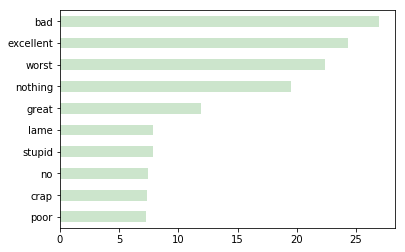

In [29]:
feature_names = vectorizer.get_feature_names()

feature_chi_series = pd.Series(chi_values, index=feature_names)

feature_chi_series.dropna().sort_values(ascending=True)[-10:].plot.barh(figsize=(6,4), align='center', alpha=.2, color='g')
plt.show()

### Using scikit-learn [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

In [59]:
X_train_vect = vectorizer.transform(X_train)

ch2_selector = SelectKBest(chi2, k=10)
ch2_selector.fit(X_train_vect, y_train)

X_train_vect_new = ch2_selector.transform(X_train_vect)

In [60]:
X_train_vect_new

<3500x10 sparse matrix of type '<class 'numpy.float64'>'
	with 4566 stored elements in Compressed Sparse Row format>

In [62]:
new_features = np.array(vectorizer.get_feature_names())[ch2_selector.get_support()]
new_features

array(['bad', 'crap', 'excellent', 'great', 'lame', 'no', 'nothing',
       'poor', 'stupid', 'worst'], dtype='<U25')

In [66]:
pd.DataFrame(X_train_vect_new.todense(), columns=new_features).head()

,bad,crap,excellent,great,lame,no,nothing,poor,stupid,worst
0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.080319,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.235556
3,0.000000,0.0,0.0,0.00000,0.0,0.043004,0.0,0.0,0.0,0.000000
4,0.050425,0.0,0.0,0.05012,0.0,0.045213,0.0,0.0,0.0,0.073941


# Most frequent classifiers

* [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html): `from sklearn.naive_bayes import MultinomialNB`
* [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `from sklearn.neighbors import KNeighborsClassifier`  
  Unlike the multinomial naive Bayes this classifier can handle negative numbers, useful after data transformations like SVD or PCA. This is a very good classifier with which to make a case for dimensionality reduction, since in a very high-dimensional space, the vector distances will most of the time be useless.
* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): `from sklearn.ensemble import RandomForestClassifier`


# Extra features using Spacy

In [70]:
df_xf = df.copy()
df_xf.head()

,sentiment,text
0,Negative,"Aldolpho (Steve Buscemi), an aspiring film mak..."
1,Negative,"An unfunny, unworthy picture which is an undes..."
2,Negative,A failure. The movie was just not good. It has...
3,Positive,I saw this movie Sunday afternoon. I absolutel...
4,Negative,Disney goes to the well one too many times as ...


Complete sentence lenght.

In [81]:
df_xf['len'] = df_xf['text'].map(len)
df_xf.head()

,sentiment,text,len,nwords
0,Negative,"Aldolpho (Steve Buscemi), an aspiring film mak...",1214,218
1,Negative,"An unfunny, unworthy picture which is an undes...",121,22
2,Negative,A failure. The movie was just not good. It has...,750,145
3,Positive,I saw this movie Sunday afternoon. I absolutel...,698,136
4,Negative,Disney goes to the well one too many times as ...,1331,230


(0, 3000)

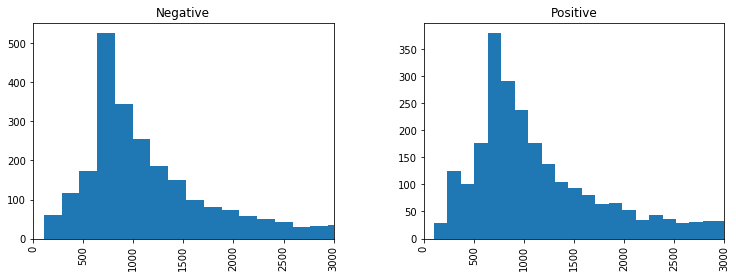

In [73]:
ax_list = df_xf.hist(column='len', by='sentiment', bins=50,figsize=(12,4))
ax_list[0].set_xlim((0,3000))
ax_list[1].set_xlim((0,3000))

Number of words.

In [74]:
df_xf['nwords'] = df_xf['text'].str.split().map(len)

In [78]:
df_xf.groupby('sentiment').mean()

,len,nwords
sentiment,,
Negative,1325.225255,234.852138
Positive,1366.011395,240.082515


In [104]:
positive_common_words = build_vocabulary(df_xf[df.sentiment == 'Positive'].text)
positive_common_words

OrderedDict([('the', 30675),
             ('and', 17218),
             ('a', 16316),
             ('of', 15501),
             ('to', 13453),
             ('is', 11589),
             ('in', 9357),
             ('that', 6616),
             ('I', 6460),
             ('it', 5631),
             ('this', 5305),
             ('/><br', 5194),
             ('as', 4968),
             ('with', 4540),
             ('was', 4368),
             ('for', 4310),
             ('but', 3442),
             ('The', 3412),
             ('his', 3348),
             ('on', 3208),
             ('are', 3049),
             ('movie', 2861),
             ('film', 2840),
             ('you', 2672),
             ('not', 2624),
             ('have', 2526),
             ('he', 2433),
             ('by', 2414),
             ('be', 2411),
             ('one', 2211),
             ('an', 2169),
             ('at', 2111),
             ('who', 2098),
             ('from', 2044),
             ('all', 1941),
             ('has',

## Loading and using Spacy

In [85]:
# load the medium-sized SpaCy model
nlp = spacy.load('en_core_web_md')

In [86]:
# Create a list of SpaCy "Docs" by leveraging the SpaCy pipeline
docs = list(nlp.pipe(df_xf['text']))

### Counting verbs: 1st option

In [112]:
n_verbs = []

for doc in docs:
    
    verbs_count = 0
    for token in doc:
        if token.pos_ == "VERB":
            verbs_count += 1
            
    n_verbs.append(verbs_count)
     
df_xf['n_verbs1'] = n_verbs

### Counting verbs: 2nd option

In [116]:
# YOUR CODE HERE
matcher = Matcher(nlp.vocab)

verb_counts = []
verbs = []

pattern = [{"POS": "VERB"}]
matcher.add('verbs', None, pattern)

for doc in docs:
    matches = matcher(doc)
    # Number of verbs
    verb_counts.append(len(matches))
    verbs_in_doc = []
    # List of verbs for each doc
    for match_id, start, end in matches:
        span = doc[start:end]  # the matched span
        span_text = span.text  # the span as a string
        verbs_in_doc.append(span_text)
    verbs.append(verbs_in_doc)

df_xf['n_verbs2'] = verb_counts

In [121]:
df_xf.groupby('sentiment').mean()

,len,nwords,n_verbs1,n_verbs2
sentiment,,,,
Negative,1325.225255,234.852138,25.876578,25.876578
Positive,1366.011395,240.082515,24.863654,24.863654


In [123]:
df_xf.head(10)

,sentiment,text,len,nwords,n_verbs1,n_verbs2
0,Negative,"Aldolpho (Steve Buscemi), an aspiring film mak...",1214,218,27,27
1,Negative,"An unfunny, unworthy picture which is an undes...",121,22,1,1
2,Negative,A failure. The movie was just not good. It has...,750,145,9,9
3,Positive,I saw this movie Sunday afternoon. I absolutel...,698,136,17,17
4,Negative,Disney goes to the well one too many times as ...,1331,230,37,37
5,Negative,Just PPV'd this. I don't want to waste too muc...,985,184,21,21
6,Negative,"I am a guy, who loves guy movies... I was look...",1009,180,25,25
7,Positive,The opening flourishes left me purring with de...,3348,586,70,70
8,Negative,Although in some aspects Seven Pounds is solid...,638,106,3,3
9,Negative,"I don't want to go off on a rant here, but.......",779,131,9,9


# Pipelining with feature unions

In [126]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]

-----

**Suggestion**: try to vary the following options/parameters and analyze its impact:

- Experiment a bit more with your preprocessing and see its impact
- Try other feature extraction options such as the simple CountVectorizer
- Use smaller slices of the dataset to see how the dataset size impacts both baseline and feature selected results
- Experiment with other classifiers and the impact of the dimensionality reduction on these
- Try to use the model to evaluate other text data, search for republican/democrat posts/news/blogs and see how well your model classifies each, for example political speeches.

-----